<a href="https://colab.research.google.com/github/yumi9647/Deep-Learning-Projects/blob/master/2_Deep_Leaning_Project(plant).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import numpy as np
import os
import pandas as pd
import seaborn as sns
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
import cv2
from glob import glob
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import math # MATHEMATICAL OPERATIONS
import itertools

scale = 70
seed = 7

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/Colab Notebooks"

'2-Deep Leaning Project(plant).ipynb'  'Deep Leaning Project(plant).ipynb'
 colab3_mlp_mnist.ipynb		        Fashion_MNIST_0.9094.ipynb
 colab5_cnn_visualization.ipynb         Fashion_MNIST_0.91.ipynb
 colab7_Autoencoder.ipynb	        train
 copy_Fashion_MNIST_0.91.ipynb	        Untitled0.ipynb


In [0]:
path_to_images = '/content/drive/My Drive/Colab Notebooks/train/*/*.png'
images = glob(path_to_images)
trainingset = []
traininglabels = []
num = len(images)
count = 1
for i in images:
    print(str(count)+'/'+str(num),end='\r')
    trainingset.append(cv2.resize(cv2.imread(i),(scale,scale)))
    traininglabels.append(i.split('/')[-2])
    count=count+1
trainingset = np.asarray(trainingset)
traininglabels = pd.DataFrame(traininglabels)

In [0]:
len(trainingset)

4750

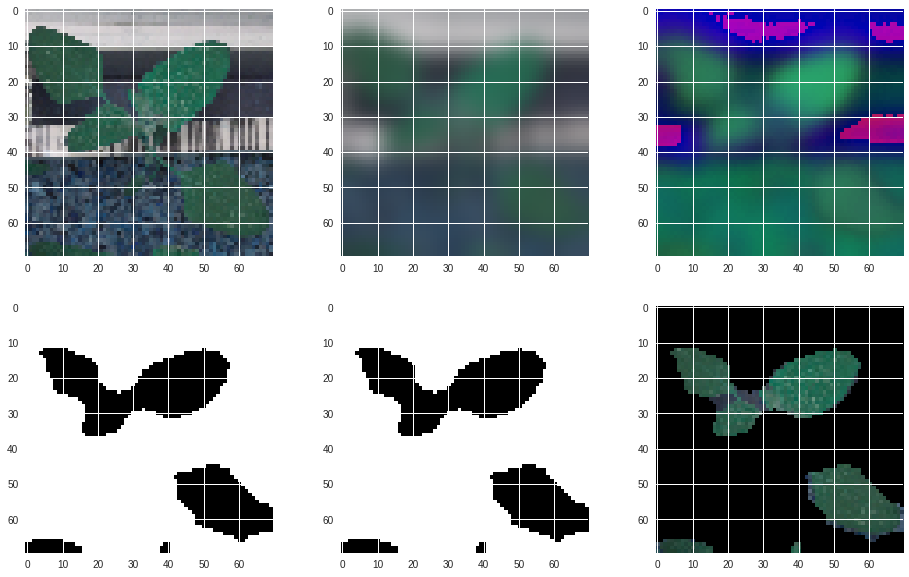

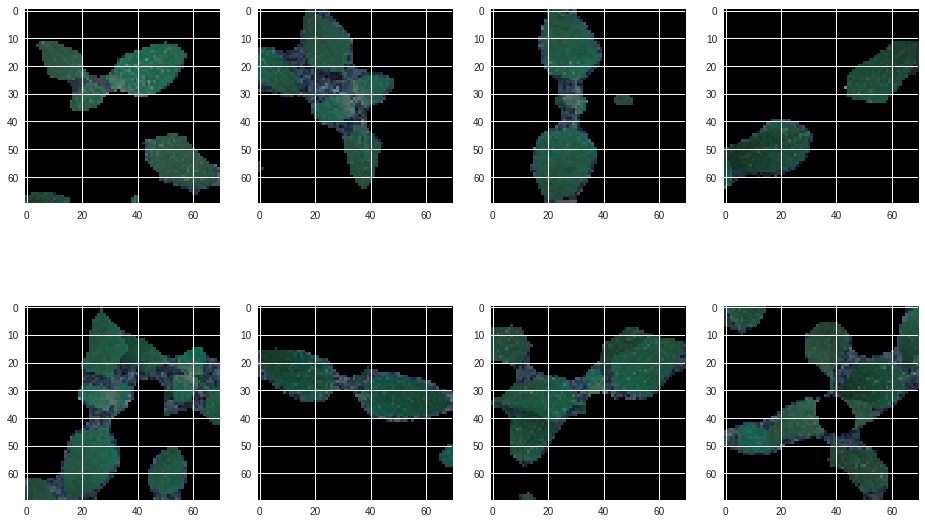

In [0]:
new_train = []
sets = []; getEx = True
for i in trainingset:
    blurr = cv2.GaussianBlur(i,(0,0),3)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    #GREEN PARAMETERS
    lower = (25,100,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    new_train.append(new)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) # ORIGINAL
        plt.subplot(2,3,2);plt.imshow(blurr) # BLURRED
        plt.subplot(2,3,3);plt.imshow(hsv) # HSV CONVERTED
        plt.subplot(2,3,4);plt.imshow(mask) # MASKED
        plt.subplot(2,3,5);plt.imshow(boolean) # BOOLEAN MASKED
        plt.subplot(2,3,6);plt.imshow(new) # NEW PROCESSED IMAGE
        plt.show()
        getEx = False
new_train = np.asarray(new_train)

# CLEANED IMAGES
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_train[i])

In [0]:
len(new_train)

4750

In [0]:
def generate_images(imgs):
    imgs_len = len(imgs)
    image_generator = ImageDataGenerator(
        rotation_range = 10, width_shift_range = 0.1 , height_shift_range = 0.1,
        horizontal_flip = False, vertical_flip = False, zoom_range = 0.1)

    imgs = image_generator.flow(imgs.copy(), np.zeros(imgs_len), batch_size=imgs_len, shuffle = False).next()    
  
# return transformed images in the same order as the original ones
    return imgs[0]

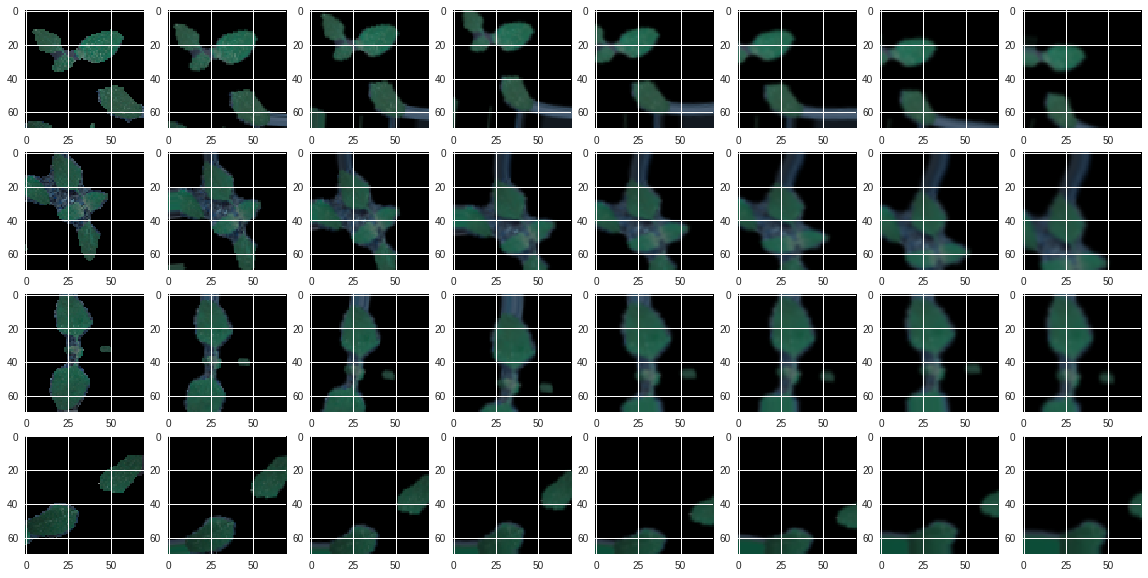

In [0]:
if True:
    #imgs = (((new_train[0:4]+1.)/2.)*255.) # transform pixels into range [0,255]
    #imgs_generated = imgs

    fig, axs = plt.subplots(4, 8, figsize=(20, 10))
    for i in range(8):
        axs[0,i].imshow(new_train[0].astype(np.uint8))
        axs[1,i].imshow(new_train[1].astype(np.uint8))
        axs[2,i].imshow(new_train[2].astype(np.uint8))
        axs[3,i].imshow(new_train[3].astype(np.uint8))   
        new_train = generate_images(new_train)

In [0]:
len(new_train)

4750

Classes['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
12


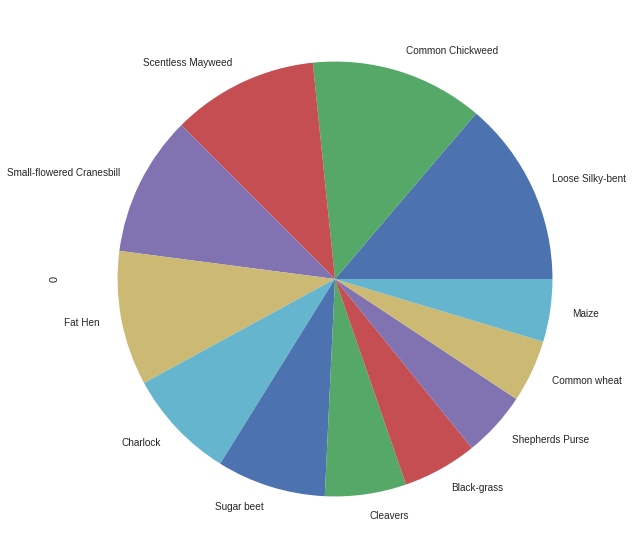

In [0]:
labels = preprocessing.LabelEncoder()
labels.fit(traininglabels[0])
print('Classes'+str(labels.classes_))
encodedlabels = labels.transform(traininglabels[0])
clearalllabels = np_utils.to_categorical(encodedlabels)
classes = clearalllabels.shape[1]
print(str(classes))
traininglabels[0].value_counts().plot(kind='pie')

In [0]:
new_train = new_train/255
x_train,x_test,y_train,y_test = train_test_split(new_train,clearalllabels,test_size=0.1,random_state=seed,stratify=clearalllabels)

In [0]:
generator = ImageDataGenerator(rotation_range = 180,zoom_range = 0.1,width_shift_range = 0.1,height_shift_range = 0.1,horizontal_flip = True,vertical_flip = True)
generator.fit(x_train)

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet', 
                  include_top = False, 
                  input_shape = (70,70,3))


Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 2s 0us/step


In [0]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 70, 70, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 70, 70, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 70, 70, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 35, 35, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 35, 35, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 35, 35, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 17, 17, 128)       0         
__________

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(classes, activation = 'softmax'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model.fit(x_train, y_train, epochs=50, batch_size = 64, validation_data=(x_test, y_test))

Train on 4275 samples, validate on 475 samples
Epoch 1/50
4275/4275 [==============================] - 914s 214ms/step - loss: 14.0444 - acc: 0.1287 - val_loss: 14.0482 - val_acc: 0.1284
Epoch 2/50
4275/4275 [==============================] - 925s 216ms/step - loss: 14.0444 - acc: 0.1287 - val_loss: 14.0482 - val_acc: 0.1284
Epoch 3/50
4275/4275 [==============================] - 919s 215ms/step - loss: 14.0444 - acc: 0.1287 - val_loss: 14.0482 - val_acc: 0.1284
Epoch 4/50
4275/4275 [==============================] - 920s 215ms/step - loss: 14.0444 - acc: 0.1287 - val_loss: 14.0482 - val_acc: 0.1284
Epoch 5/50
3904/4275 [==========================>...] - ETA: 1:17 - loss: 14.0166 - acc: 0.1304

KeyboardInterrupt: ignored

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_2 (Dense)              (None, 12)                3084      
Total params: 15,242,316
Trainable params: 15,242,316
Non-trainable params: 0
_________________________________________________________________


In [0]:
seed = 1987
data_dir = '/content/drive/My Drive/Colab Notebooks'
train_dir = os.path.join(data_dir, 'train')
#test_dir = os.path.join(data_dir, 'test')
#sample_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

In [0]:
!ls '/content/drive/My Drive/Colab Notebooks/train'

 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherds Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [0]:
train_dir

'/content/drive/My Drive/Colab Notebooks/train'

In [0]:
os.listdir(train_dir)

['Fat Hen',
 'Sugar beet',
 'Loose Silky-bent',
 'Common Chickweed',
 'Common wheat',
 'Cleavers',
 'Scentless Mayweed',
 'Small-flowered Cranesbill',
 'Shepherds Purse',
 'Black-grass',
 'Maize',
 'Charlock']

In [0]:
class_folder_path

NameError: ignored

In [0]:
images_per_class = {}
for class_folder_name in os.listdir(train_dir):
    class_folder_path = os.path.join(train_dir, class_folder_name)
    class_label = class_folder_name
    images_per_class[class_label] = []
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images_per_class[class_label].append(image_bgr)

In [0]:
for key,value in images_per_class.items():
    print("{0} -> {1}".format(key, len(value)))

Fat Hen -> 475
Sugar beet -> 385
Loose Silky-bent -> 654
Common Chickweed -> 611
Common wheat -> 221
Cleavers -> 287
Scentless Mayweed -> 516
Small-flowered Cranesbill -> 496
Shepherds Purse -> 231
Black-grass -> 263
Maize -> 221
Charlock -> 390


In [0]:
def plot_for_class(label):
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))
    fig.suptitle(label, fontsize=16, color='r')

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(images_per_class[label][n])
            n += 1    

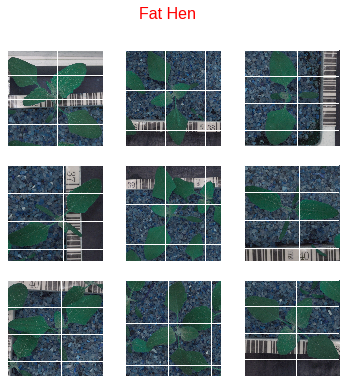

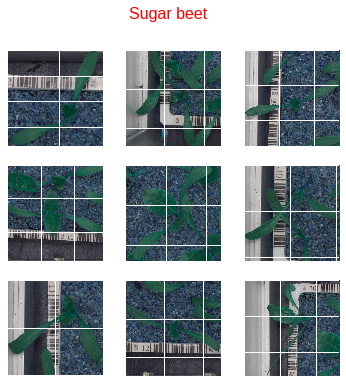

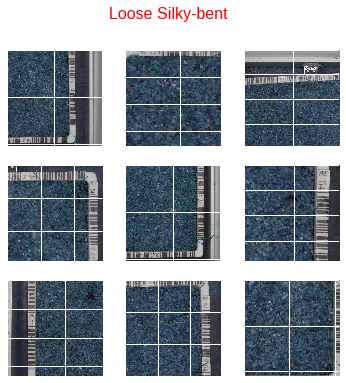

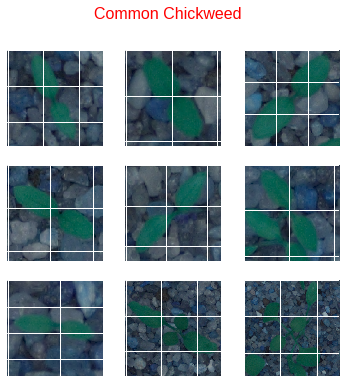

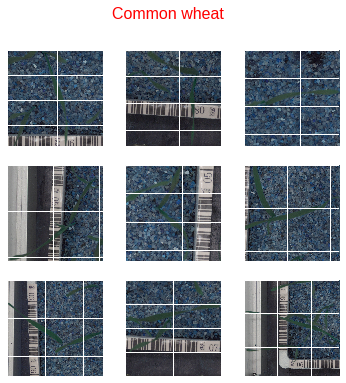

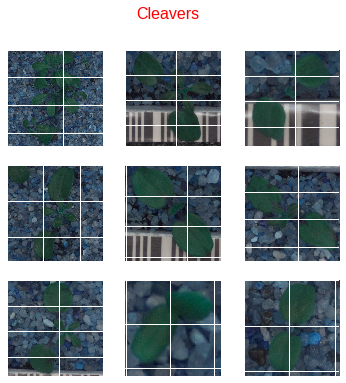

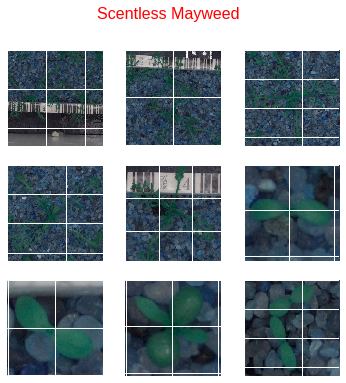

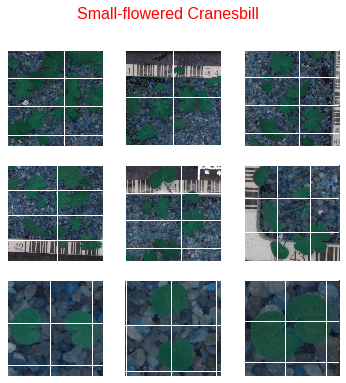

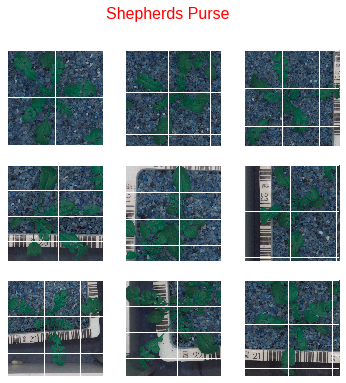

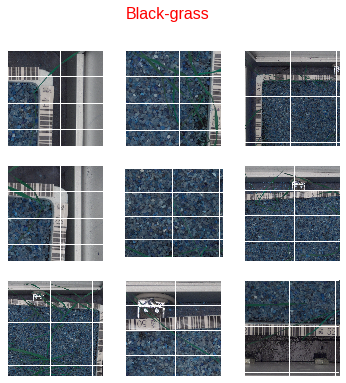

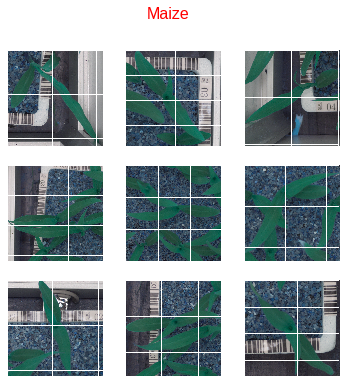

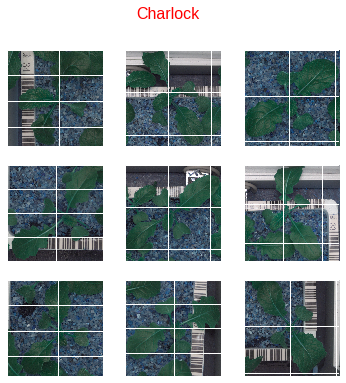

In [0]:
for class_folder_name in os.listdir(train_dir):
    plot_for_class(class_folder_name)

In [0]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

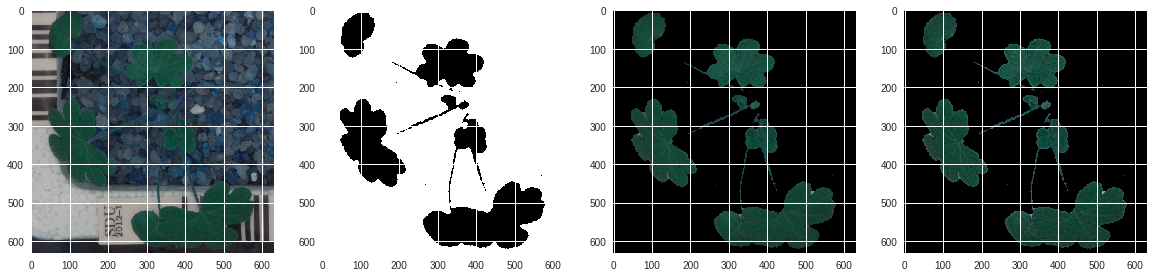

In [0]:
image = images_per_class["Small-flowered Cranesbill"][97]

image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)

In [0]:
segmented = []

for class_label in images_per_class.keys():
    for image in images_per_class[class_label]:
        image_segmented = segment_plant(image)
        segmented.append(image_segmented)

#Kaggle Kernal 


In [0]:
def find_contours(mask_image):
    return cv2.findContours(mask_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

def calculate_largest_contour_area(contours):
    if len(contours) == 0:
        return 0
    c = max(contours, key=cv2.contourArea)
    return cv2.contourArea(c)

def calculate_contours_area(contours, min_contour_area = 250):
    area = 0
    for c in contours:
        c_area = cv2.contourArea(c)
        if c_area >= min_contour_area:
            area += c_area
    return area

In [0]:
areas = []
larges_contour_areas = []
labels = []
nb_of_contours = []
images_height = []
images_width = []

for class_label in images_per_class.keys():
    for image in images_per_class[class_label]:
        mask = create_mask_for_plant(image)
        contours = find_contours(mask)
        
        area = calculate_contours_area(contours)
        largest_area = calculate_largest_contour_area(contours)
        height, width, channels = image.shape
        
        images_height.append(height)
        images_width.append(width)
        areas.append(area)
        nb_of_contours.append(len(contours))
        larges_contour_areas.append(largest_area)
        labels.append(class_label)

In [0]:
features_df = pd.DataFrame()
features_df["label"] = labels
features_df["area"] = areas
features_df["largest_area"] = larges_contour_areas
features_df["number_of_components"] = nb_of_contours
features_df["height"] = images_height
features_df["width"] = images_width

In [0]:
features_df.head(5)

,label,area,largest_area,number_of_components,height,width
0,Fat Hen,283233.5,263429.0,20,965,965
1,Fat Hen,308726.0,85060.5,30,1199,1199
2,Fat Hen,151993.5,74036.5,88,897,897
3,Fat Hen,147907.5,65514.0,22,858,858
4,Fat Hen,433660.0,279051.0,13,1210,1210
